In [1]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE
import pandas as pd
from scipy.stats import mode

In [2]:
#%% Load Data

# Load features from data.csv
features = []
path = '/content/drive/MyDrive/classification_data_2024/'

with open(path+'data.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        features.append([float(val) for val in row])

# Convert the list of features into a NumPy array
features_array = np.array(features)

# Load labels from labels.csv (assuming it's structured similarly)
labels = []
with open(path+'labels.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        labels.append(int(row[0]))  # Assuming the label is in the first column

# Convert the list of labels into a NumPy array
labels_array = np.array(labels)

# Save the array with labeled features
labeled_features_array = features_array[:179]

Descriptive Analysis: Feature Averages & Dispersion

Class 0: 156 instances
Class 1: 23 instances


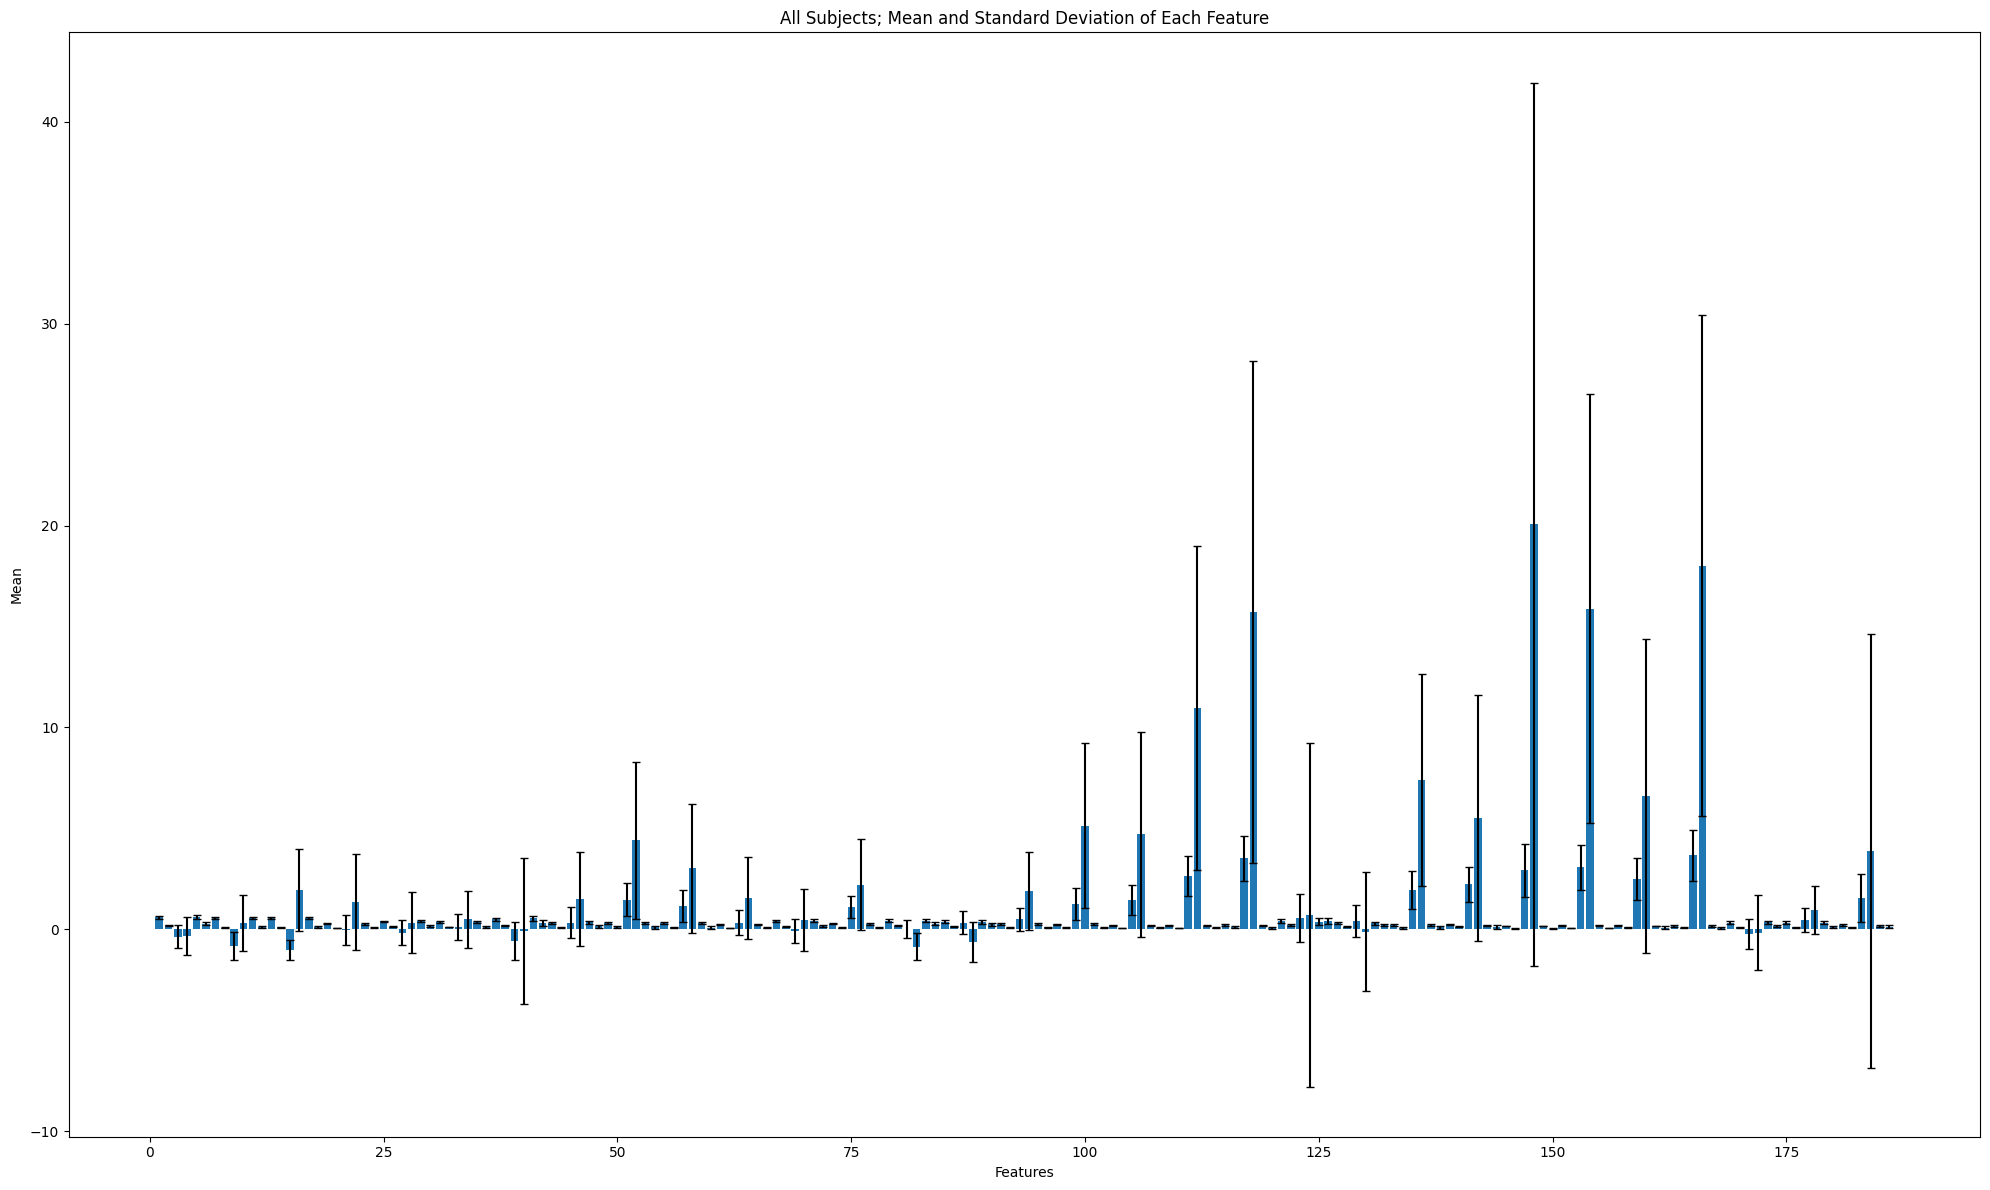

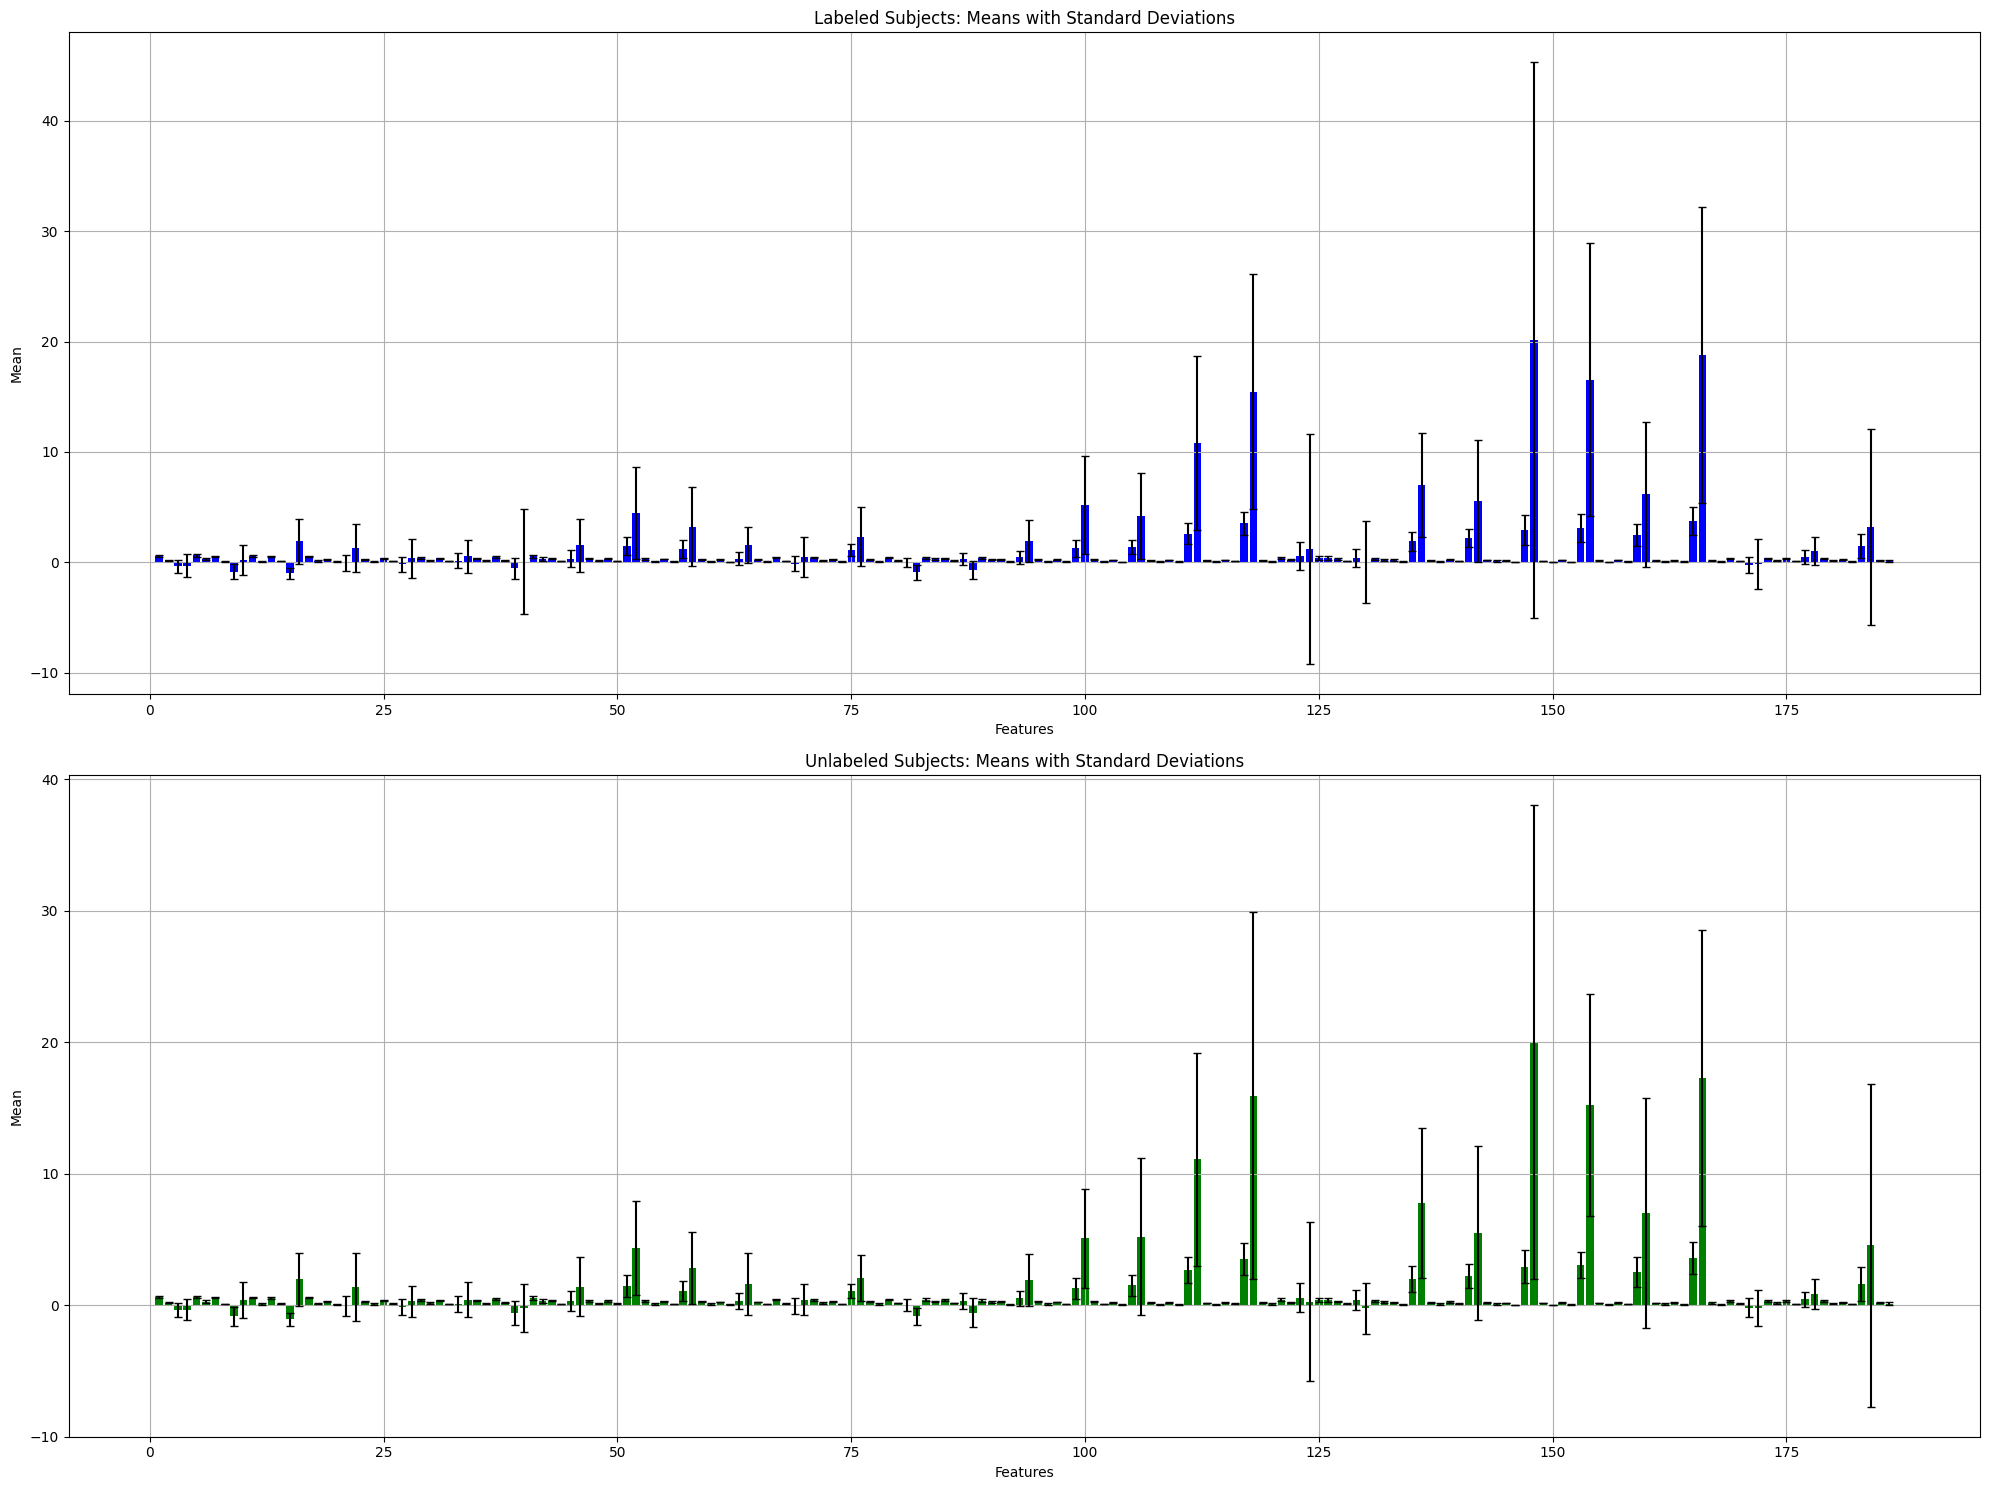

In [3]:

# Get unique labels and their counts
unique_labels, label_counts = np.unique(labels_array, return_counts=True)
for index, label in enumerate(unique_labels):
    print("Class "+str(label-1)+": "+str(label_counts[index])+" instances")
# Calculate mean and standard deviation for each feature (column)
means = np.mean(features_array, axis=0)
std_devs = np.std(features_array, axis=0)
# Error Plot for Features
plt.figure(figsize=(20, 12))
plt.bar(np.arange(1, 187), means, yerr=std_devs, capsize=3)
plt.xlabel('Features')
plt.ylabel('Mean')
plt.title('All Subjects; Mean and Standard Deviation of Each Feature')
plt.tight_layout()
plt.show()

# Calculate mean and standard deviation for each feature (column)
means_labeled = np.mean(features_array[:179], axis=0)
std_devs_labeled = np.std(features_array[:179], axis=0)
means_unlabeled = np.mean(features_array[179:], axis=0)
std_devs_unlabeled = np.std(features_array[179:], axis=0)
# Error Plots for Features of Labeled and Unlabeled Subject Distributions
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))
# Plot for Labeled Subjects
ax1.bar(np.arange(1, 187), means_labeled, yerr=std_devs_labeled, capsize=3, color='blue')
ax1.set_title('Labeled Subjects: Means with Standard Deviations')
ax1.set_xlabel('Features')
ax1.set_ylabel('Mean')
ax1.grid(True)
# Plot for Unlabeled Subjects
ax2.bar(np.arange(1, 187), means_unlabeled, yerr=std_devs_unlabeled, capsize=3, color='green')
ax2.set_title('Unlabeled Subjects: Means with Standard Deviations')
ax2.set_xlabel('Features')
ax2.set_ylabel('Mean')
ax2.grid(True)
# Show the plot
plt.tight_layout()
plt.show()


Exploratory Analysis: Intrinsic Variation of Data with Principal Component Analysis

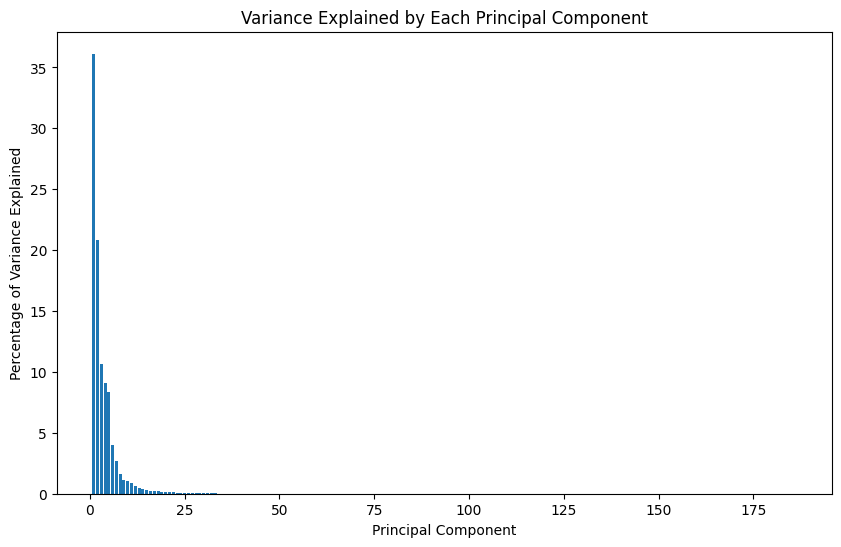

Number of components explaining 85% variance:5
Number of components explaining 90% variance:7
Number of components explaining 95% variance:10


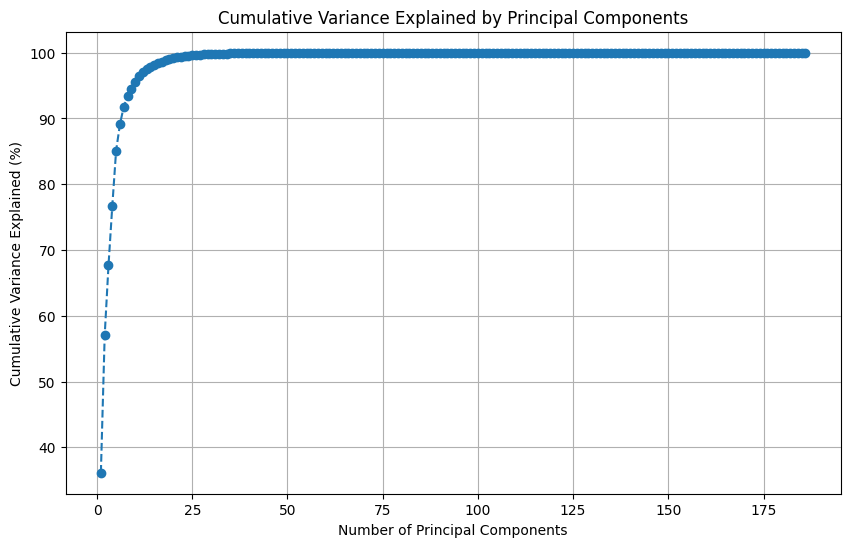

In [4]:

# Optional: Already Implemented on Sklearn's PCA
# Center data by subtracting the mean from each feature
features_mean = np.mean(features_array, axis=0)
features_centered = features_array - features_mean

# Apply PCA
pca = PCA()
pca.fit(features_centered)

# Get the explained variance ratio (percentage of variance explained by each component)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance for each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Cumulative variance explained by each component
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find the number of components that explain 85%, 90%, and 95% of the variance
components_85 = np.argmax(cumulative_variance >= 0.85) + 1
components_90 = np.argmax(cumulative_variance >= 0.90) + 1
components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print("Number of components explaining 85% variance:" + str(components_85))
print("Number of components explaining 90% variance:" + str(components_90))
print("Number of components explaining 95% variance:" + str(components_95))

# Plot the cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()


Exploratory Analysis: Potential Feature Importance for Independent Variable

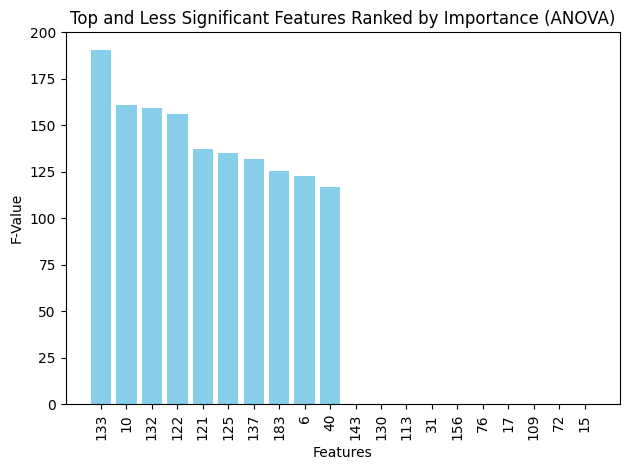

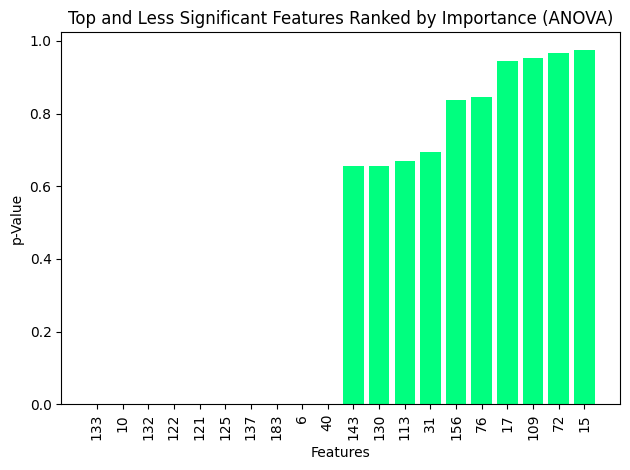

In [5]:

# Compute F and p values with f_classif (ANOVA)
f_values, p_values = f_classif(features_array[:179], labels_array)
# Sort based on p_values (ascending order - most important indices in front)
sorted_indices = np.argsort(p_values)
# Select top 10 most important and bottom 10 least important indices
top_features_indices = sorted_indices[:10]
least_significant_features_indices = sorted_indices[-10:]
# Merge Top and Bottom indices
selected_indices = np.concatenate([top_features_indices, least_significant_features_indices])

# BarPlot - F-value
plt.figure()
plt.bar(range(len(selected_indices)), f_values[selected_indices], color='skyblue')
plt.xlabel('Features')
plt.ylabel('F-Value')
plt.title('Top and Less Significant Features Ranked by Importance (ANOVA)')
plt.xticks(ticks=range(len(selected_indices)), labels=selected_indices, rotation=90)
plt.tight_layout()
plt.show()

# BarPlot - p-value
plt.figure()
plt.bar(range(len(selected_indices)), p_values[selected_indices], color='springgreen')
plt.xlabel('Features')
plt.ylabel('p-Value')
plt.title('Top and Less Significant Features Ranked by Importance (ANOVA)')
plt.xticks(ticks=range(len(selected_indices)), labels=selected_indices, rotation=90)
plt.tight_layout()
plt.show()



Exploratory Analysis: Get holistic view of data with PCA and T-SNE

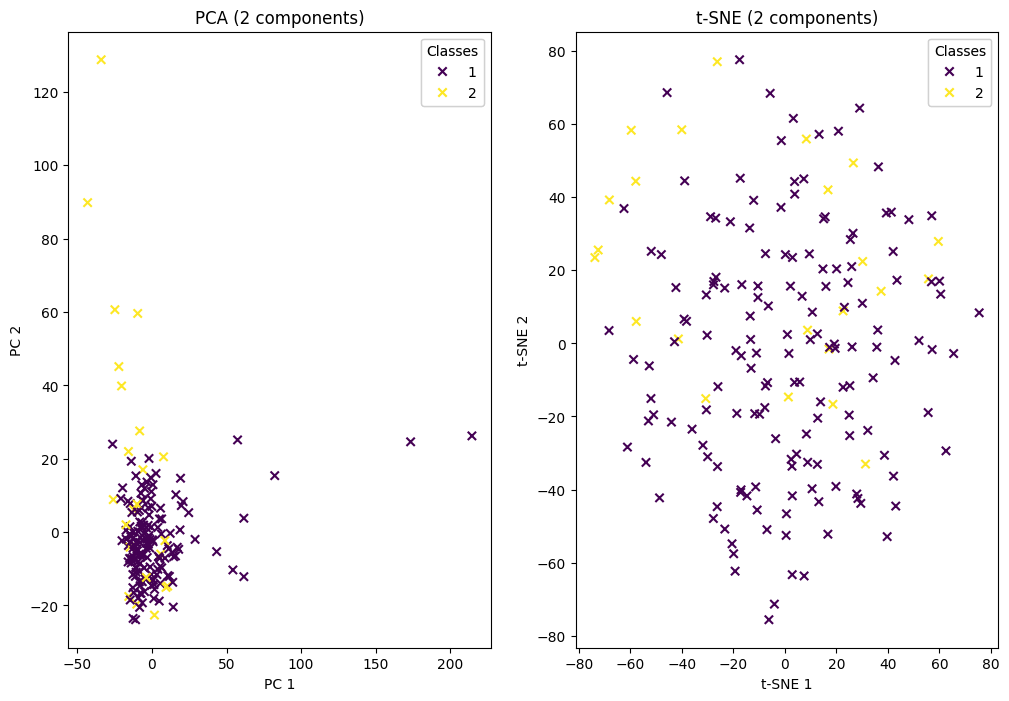

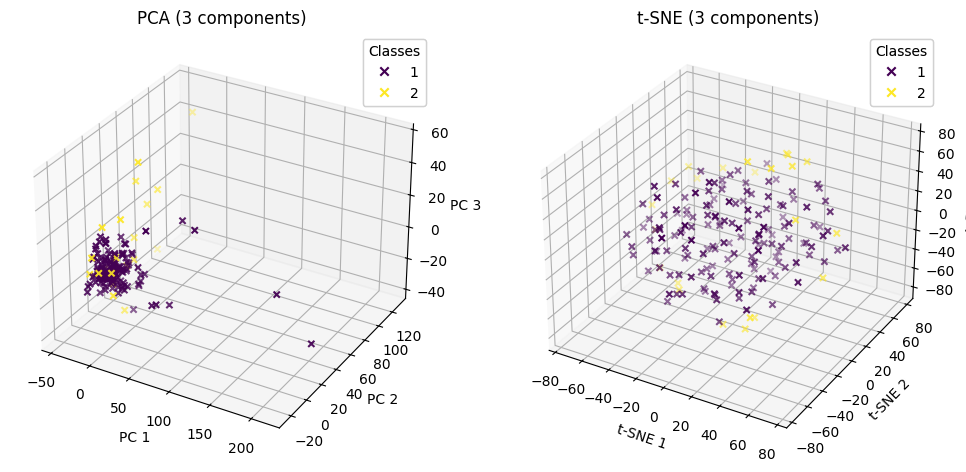

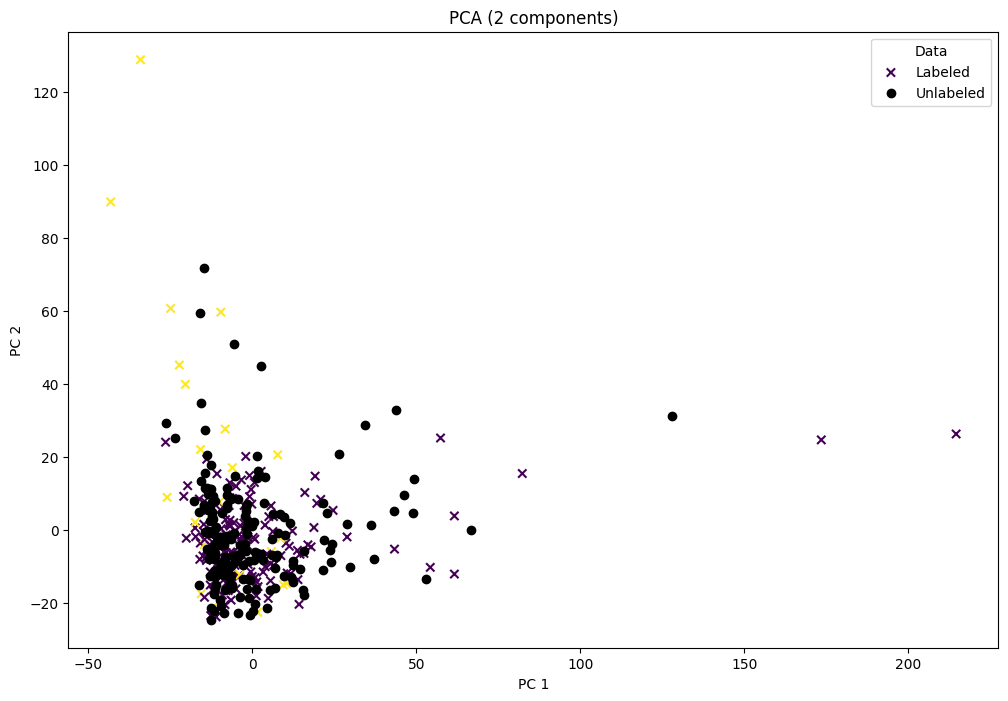

In [6]:

# Center labeled data
labeled_features_mean = np.mean(features_array[:179], axis=0)
labeled_features_centered = features_array[:179] - labeled_features_mean
# Center unlabeled data
unlabeled_features_centered = features_array[179:] - labeled_features_mean

# PCA
pca_labeled = PCA(n_components=3, random_state = 20)
feat_pca = pca_labeled.fit_transform(labeled_features_centered)
# Transform unlabeled features with PCA
feat_unlabeled_pca = pca_labeled.transform(unlabeled_features_centered)

# tSNE
tsne = TSNE(n_components=3, random_state = 20)  # 2D for visualization
feat_tsne = tsne.fit_transform(labeled_features_centered)


# PLOT FOR 2 COMPONENTS:
# ------------------------
# Create a 2D scatter plot
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
# Scatter plot
scatter1 = ax1.scatter(feat_pca[:, 0], feat_pca[:, 1], c=labels, cmap='viridis', marker='x')
# Set labels
ax1.set_title('PCA (2 components)')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
legend1 = ax1.legend(*scatter1.legend_elements(),title="Classes")
ax1.add_artist(legend1)

ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(feat_tsne[:, 0], feat_tsne[:, 1], c=labels, cmap='viridis', marker='x')
ax2.set_title('t-SNE (2 components)')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
# Add a legend for t-SNE
legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
ax2.add_artist(legend2)
plt.show()


# PLOT FOR 3 COMPONENTS:
# ------------------------
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
# Scatter plot
scatter1 = ax1.scatter(feat_pca[:, 0], feat_pca[:, 1], feat_pca[:, 2], c=labels, cmap='viridis', marker='x')
# Set labels
ax1.set_title('PCA (3 components)')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_zlabel('PC 3')
# Add a legend for PCA
legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes")
ax1.add_artist(legend1)
# Create a 3D scatter plot for t-SNE
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(feat_tsne[:, 0], feat_tsne[:, 1], feat_tsne[:, 2], c=labels, cmap='viridis', marker='x')
ax2.set_title('t-SNE (3 components)')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
# Add a legend for t-SNE
legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
ax2.add_artist(legend2)
plt.show()


# PLOT FOR 2 COMPONENTS with unlabeled data:
# ------------------------
# Create a 2D scatter plot
plt.figure(figsize=(12, 8))
# Scatter plot
scatter1 = plt.scatter(feat_pca[:, 0], feat_pca[:, 1], c=labels, cmap='viridis', marker='x')
# Plot unlabeled features
scatter2 = plt.scatter(feat_unlabeled_pca[:, 0], feat_unlabeled_pca[:, 1], c='black', marker='o', label='No Label')
# Set labels
plt.title('PCA (2 components)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(['Labeled','Unlabeled'],title="Data")
plt.show()
